# VGG-16 on Multi GPU PyTorch

In [1]:
import torch

**Check for the number of available GPU(s)**

In [2]:
num = torch.cuda.device_count()
print("There are %d available GPU(s)"%(num))

for i in range(num): #print the name of the GPUs
    
    print("GPU Num %d :"%(i+1), torch.cuda.get_device_name(i))

There are 2 available GPU(s)
GPU Num 1 : GeForce GTX 1080 Ti
GPU Num 2 : GeForce GTX 1080 Ti


### With Batch Normalization

![](vgg_16.png)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage import io, transform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.autograd import Variable
import torch.nn as NN
from torch.optim import Adam, SGD
import time

### Prepare Dataset

In [4]:
train = pd.read_csv('emergency_vs_non-emergency_dataset/emergency_train.csv')
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [5]:
class loading_dataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.csv_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.root_dir + '/' +self.csv_file['image_names'][idx]
        img = io.imread(img_path)
        img = img/255
        img = transform.resize(img, (224,224))
        label = np.array(self.csv_file['emergency_or_not'][idx]).astype(int)
        
        sample = {'image':img, 'label':label}
        
        if self.transform:
            sample = self.transform(sample)
        
        
        return sample

0 (224, 224, 3)
1 (224, 224, 3)
2 (224, 224, 3)
3 (224, 224, 3)
4 (224, 224, 3)


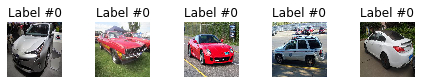

In [6]:
load_image = loading_dataset(csv_file='emergency_vs_non-emergency_dataset/emergency_train.csv', 
                   root_dir='emergency_vs_non-emergency_dataset/images')


fig = plt.figure()

#show some samples
for i in range(5):
    
    sample = load_image[i]
    print(i, sample['image'].shape)
    
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title("Label #{}".format(sample['label']))
    ax.axis('off')
    plt.imshow(sample['image'])

In [7]:
class ToTensor:
    
    def __init__(self):
        pass
    
    def __call__(self, sample):
        
        image, label = sample['image'], sample['label']
        
        image = image.transpose((2,0,1))
        return {'image': torch.from_numpy(image.astype('float32')),
                'label': torch.from_numpy(label)}

In [8]:
load_image = loading_dataset(csv_file='emergency_vs_non-emergency_dataset/emergency_train.csv', 
                             root_dir='emergency_vs_non-emergency_dataset/images',
                             transform=transforms.Compose([ToTensor()]))

batch_size = 50
dataloader = DataLoader(load_image, batch_size=batch_size, shuffle=True, num_workers=4)

### VGG-16

In [9]:
class VGG_16(NN.Module):
    
    def _initialize_weights(self):
            
        for m in self.modules():

            if isinstance(m, NN.Conv2d):
                NN.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    NN.init.constant_(m.bias, 0)
            elif isinstance(m, NN.BatchNorm2d):
                NN.init.constant_(m.weight, 1)
                NN.init.constant_(m.bias, 0)
            elif isinstance(m, NN.Linear):
                NN.init.normal_(m.weight, 0, 0.01)
                NN.init.constant_(m.bias, 0)      
    
    def __init__(self, num_classes=2, init_weights=True):
        
        super(VGG_16, self).__init__()
        
        self.cfgs = {
            #architecture of VGG-16. M stands for max-pooling. The numbers are the output channel for each layer.
            'vgg_16':[64,64, 'M', 128,128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        }
        
        layers = []
        in_channels = 3
        
        #construct the convolutional layers based on the configuration.
        for v in self.cfgs['vgg_16']:
            
            if v == 'M': #max pooling
                layers += [NN.MaxPool2d(kernel_size=2, stride=2)]
            else:
                #convolutional layer with input and output channel as specified.
                conv2d = NN.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, NN.BatchNorm2d(num_features=v), NN.ReLU(inplace=True)]
                in_channels=v #update
        
        self.features= NN.Sequential(*layers) #unpack the layers
        self.avgpool = NN.AdaptiveAvgPool2d((7,7)) #NOT SURE WHY THIS IS REQUIRED.
        
        #NN.sequential makes sure the layers are executed in order.
        ##The fully-connected layers were suppose to output 4096 channels. I reduced it to 2048 for this problem.
        self.classifier = NN.Sequential(
                            NN.Linear(512*7*7, 4096),
                            NN.ReLU(inplace=True),
                            NN.Dropout(),
                            NN.Linear(4096,4096),
                            NN.ReLU(inplace=True),
                            NN.Dropout(),
                            NN.Linear(4096, num_classes)
        )
        
        if init_weights:
            self._initialize_weights()
            
    def forward(self, input_x):
        
        x = self.features(input_x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        print("\tIn Model: input size", input_x.size(),
              "output size", out.size())
        return out
    

vgg = VGG_16()
# vgg.load_state_dict(torch.load('./model_ckpt/model.pth')) #to load previous checkpoints
#vgg.eval() #this is required for inference. It'll set dropout and batch normalization layers to eval mode.
optimizer= Adam(vgg.parameters(), lr=1e-4)
criterion = NN.CrossEntropyLoss() #One-Hot encoding is already implemented in CEL.

if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), " GPUs!")
    vgg = NN.DataParallel(vgg) #Move the model to the available GPUs
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg.to(device)

print(vgg)

Using  2  GPUs!
DataParallel(
  (module): VGG_16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, 

**Training**

In [10]:

epoch_range = 10

start_time = time.time()
for epoch in range(epoch_range):
    
    epoch_loss = 0
    
#     permutation = torch.randperm(train_x.size()[0]) #returns a tensor with randomly arranged numbers from 0 to size
    
    training_loss = []
    
    for batch_i, sample_batched in enumerate(dataloader):
        
        batch_x, batch_y = sample_batched['image'].to(device), sample_batched['label'].to(device)
        

        optimizer.zero_grad()
        
        outputs = vgg(batch_x)
        loss = criterion(outputs, batch_y)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if epoch == 0 and batch_i == 0:
            print("Outside: Input size :", batch_x.size(),
                  'Output size : ', outputs.size())
        
    training_loss = np.average(training_loss)
    print("Epoch %d, \t Loss : %g"%(epoch, training_loss))

end_time = time.time()
print("It took %g s to run the training for %d epoch with %d batch sizes."%((end_time-start_time), epoch_range, batch_size))

	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
Outside: Input size : torch.Size([50, 3, 224, 224]) Output size :  torch.Size([50, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224])  torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])output size torch.Size([25, 2])

	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Siz

	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size  torch.Size([25, 3, 224, 224]) torch.Size([25, 3, 224, 224]) output sizeoutput size torch.Size([25, 2]) torch.Size([25, 2])

	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size  torch.Size([25, 3, 224, 224]) torch.Size([25, 3, 224, 224]) output sizeoutput size torch.Size([25, 2]) torch.Size([25, 2])

	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([

	In Model: input size torch.Size([23, 3, 224, 224]) output size torch.Size([23, 2])
	In Model: input size torch.Size([23, 3, 224, 224]) output size torch.Size([23, 2])
Epoch 2, 	 Loss : 0.436758
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])	In Model: input size
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224

	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size  torch.Size([25, 3, 224, 224]) torch.Size([25, 3, 224, 224]) output sizeoutput size torch.Size([25, 2]) torch.Size([25, 2])

	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([

	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([23, 3, 224, 224]) output size torch.Size([23, 2])
	In Model: input size torch.Size([23, 3, 224, 224]) output size torch.Size([23, 2])
Epoch 5, 	 Loss : 0.247563
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224

	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 3, 224, 224])  torch.Size([25, 2])
output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size	In Model: input size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size  torch.Size([25, 3, 224, 224]) output sizetorch.Size([25, 2])
 torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([

	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
 torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([23, 3, 224, 224]) output size torch.Size([23, 2])
 torch.Size([23, 3, 224, 224]) output size torch.Size([23, 2])
Epoch 8, 	 Loss : 0.168041
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224])  output size torch.Size([25, 2])
torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2])
	In Model: input size	In Model: input size torch.Size([25, 3, 224, 224]) output size torch.Size([25, 2]) torch.Size([25, 3, 224, 224]

### Conclusion

Comparing with the same model with the same data that uses only 1 GPU, utilizing 2 GPUs enable the training to be done approximately 40 seconds faster. Note that the GPUs were not connected with SLI bridge cables. However, the code works by utilizing both the GPUs as can be seen that the input to the model is divided evenly.